# CARNIELLI Ariana n. 3525837

# TME sur la classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

with open('ressources/lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [2]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [3]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    plt.savefig("exlettre.png")
    return

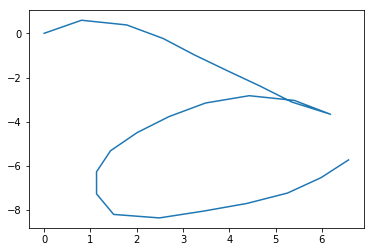

In [4]:
tracerLettre(X[0])

##  Apprentissage d'un modèle CM (max de vraisemblance)
### 1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats`
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [5]:
def discretise(X,nbEtats):
    intervalle = 360 / nbEtats
    res = np.empty(X.shape, dtype = X.dtype)
    for i in range(X.size): 
        res[i] = np.floor(X[i]/intervalle)
    return res

**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2.,  2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

In [6]:
#On teste le résultat obtenu pour le premier signal 
#avec une discrétisation sur 3 états:

nbEtats = 3
X3Etats = discretise(X, nbEtats)
print(X3Etats[0])
print(np.allclose(X3Etats[0], [0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 
                  1., 1., 2., 2., 2., 2., 0., 0., 0., 0., 0.]))
    

[0. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0.]
True


### 2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [7]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe 

In [8]:
#groupement des signaux par classe

index = groupByLabel(Y)

### 3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [9]:
def learnMarkovModel(Xc, nbEtats):
    A = np.zeros((nbEtats, nbEtats))
    Pi = np.zeros(nbEtats)
    
    for x in Xc:
        for i in range(x.size):
            if i == 0:
                Pi[int(x[i])] += 1
            else:
                ai = int(x[i - 1])
                aj = int(x[i])
                A[ai, aj] += 1
    
    A = A / np.maximum(A.sum(1).reshape(nbEtats, 1), 1) # normalisation
    Pi = Pi / Pi.sum()
    
    return Pi, A

**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

In [10]:
#On teste le premier modèle avec une discrétisation sur 3 états:

m1_3Etats = X3Etats[index[0]]
Pi, A = learnMarkovModel(m1_3Etats, nbEtats)

print(Pi)
print(A)

print(np.allclose(Pi, [ 0.36363636,  0.        ,  0.63636364]))
print(np.allclose(A, [[ 0.84444444,  0.06666667,  0.08888889],
                      [ 0.        ,  0.83333333,  0.16666667],
                      [ 0.11382114,  0.06504065,  0.82113821]]))

[0.36363636 0.         0.63636364]
[[0.84444444 0.06666667 0.08888889]
 [0.         0.83333333 0.16666667]
 [0.11382114 0.06504065 0.82113821]]
True
True


### 4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [11]:
d = 20                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[index[cl]], d))

##  Test (affectation dans les classes sur critère MV)
### 1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [12]:
def probaSequence(s, Pi, A):
    proba = 0
    for i in range(s.size):
        if i == 0:
            proba += np.log(Pi[int(s[0])])
        else:
            ai = int(s[i - 1])
            aj = int(s[i])
            proba += np.log(A[ai, aj])
    return proba

In [13]:
#on crée une fonction pour faciliter le calcul de la log-probabilité
#d'une séquence par rapport à une ensemble de modèles : 

def probasSequence(s, modeles):
    probas = np.zeros(len(modeles))
    for i, (Pi, A) in enumerate(modeles):
        probas[i] = probaSequence(s, Pi, A)
    return probas

**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?
- D'où viennent tous les `-inf` ? 

In [14]:
#On crée 26 modèles à partir de la discrétisation à 3 états et
#on calcule la log-vraisemblance du premier signal à ses 26 modèles
#à l'aide d'une fonction auxiliaire

model3 = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    model3.append(learnMarkovModel(X3Etats[index[cl]], nbEtats))

probas = probasSequence(X3Etats[0], model3)
print(probas)
print(np.allclose(probas, 
            [-13.491086  ,         -np.inf,         -np.inf,         -np.inf,
           -np.inf,         -np.inf,         -np.inf,         -np.inf,
           -np.inf,         -np.inf,         -np.inf,         -np.inf,
           -np.inf,         -np.inf,         -np.inf,         -np.inf,
           -np.inf,         -np.inf,         -np.inf,         -np.inf,
           -np.inf,         -np.inf,         -np.inf,         -np.inf,
           -np.inf, -12.48285678]))

#on a un warning a cause du log(0) qui donne -inf.

[-13.491086           -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
 -12.48285678]
True


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Non, le signal n'est pas bien classé. Le signal correspond à une lettre "a" d'après Y mais en utilisant les modèles on le classerait comme une lettre "z" (la plus grande log-probabilité parmi les 26 calculées).

Dans le calcul d'un modèle, on aura une probabilité 0 dans les matrices `A` ou `Pi` si un état initial ou une transition n'ont pas été observées dans les données utilisées pour calculer ce modèle. Ainsi, un signal qui a un de ces états initiaux ou présente une de ces transitions a une probabilité 0 d'être issu de ce modèle. Les `-inf` viennent ainsi des calculs de log(0) pour les modèles auquels le signal n'a aucun chance d'être classé.

### 2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [15]:
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

#on peut aussi faire, avec la fonction auxiliaire 
#(mais ici on a les probabilités d'un signal dans une ligne 
#et pas dans une colonne):
proba20 = np.array([probasSequence(Xd[i], models) for i in range (Xd.size)])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


### 3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [16]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
#pour nbEtats = 20

# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne
pred20 = proba20.argmax(1) # max ligne par ligne

# Calcul d'un pourcentage de bonne classification :
print("Bonne classification pour nbEtats = 20 :", np.where(pred != Ynum, 0.,1.).mean()) 
print("Bonne classification pour nbEtats = 20 :", np.where(pred20 != Ynum, 0.,1.).mean()) #avec le méthode auxiliaire
    
#pour nbEtats = 3

proba3 = np.array([probasSequence(X3Etats[i], model3) for i in range (X3Etats.size)])
pred3 = proba3.argmax(1) # max ligne par ligne
print("Bonne classification pour nbEtats = 3 :", np.where(pred3 != Ynum, 0.,1.).mean())

Bonne classification pour nbEtats = 20 : 0.914179104477612
Bonne classification pour nbEtats = 20 : 0.914179104477612
Bonne classification pour nbEtats = 3 : 0.6902985074626866


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

## Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [17]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [18]:
itrain

[array([4, 5, 2, 7, 9, 8, 6, 1]),
 array([16, 11, 19, 12, 17, 18, 20, 21]),
 array([23, 28, 27, 22, 24, 31, 30, 29]),
 array([39, 42, 36, 38, 41, 35, 37, 34]),
 array([45, 53, 49, 51, 47, 44, 46, 52]),
 array([64, 65, 60, 55, 61, 57, 59, 56]),
 array([66, 75, 69, 71, 72, 70, 67, 76]),
 array([78, 83, 82, 84, 87, 85, 80, 77]),
 array([91, 97, 94, 92, 89, 90, 93, 95]),
 array([ 98, 107, 102, 100, 106, 104, 105, 101]),
 array([114, 109, 108, 116, 110, 113, 111, 117]),
 array([118, 119, 123, 125, 121, 127, 124, 120]),
 array([128, 132, 134, 137, 131, 135, 133, 129]),
 array([142, 145, 146, 141, 139, 140, 143, 147]),
 array([153, 156, 151, 149, 155, 152, 148, 157]),
 array([167, 160, 164, 163, 165, 166, 159, 162]),
 array([170, 169, 174, 172, 168, 176, 173, 171]),
 array([186, 187, 180, 183, 185, 181, 182, 179]),
 array([194, 192, 191, 189, 188, 197, 196, 195]),
 array([205, 203, 206, 198, 202, 204, 201, 207]),
 array([208, 213, 217, 209, 210, 214, 216, 215]),
 array([225, 218, 219, 224, 22

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

In [19]:
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()

**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

## Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

In [20]:
# On crée une fonction evalModel(X, Y, nbEtats, p, learn) qui calcule le taux de bonne classification
# pour un nombre d'états donné, pour une ensemble d'apprentissage et une ensemble de test, 
# avec p = ratio de points dans l'ensemble d'apprentissage. Le paramètre facultatif learn sert à la prochaine question.

def evalModel(X, Y, nbEtats, p, learn = learnMarkovModel):
    itrain, itest = separeTrainTest(Y, p)
    ia = []
    for i in itrain:
        ia += i.tolist()    
    it = []
    for i in itest:
        it += i.tolist()

    Xd = discretise(X, nbEtats)  # application de la discrétisation
    model = []
    for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
        model.append(learn(Xd[itrain[cl]], nbEtats))
    
    proba = np.array([probasSequence(Xd[i], model) for i in range(Xd.size)])
    pred = proba.argmax(1) # max ligne par ligne
    
    Ynum = np.zeros(Y.shape)
    for num, char in enumerate(np.unique(Y)):
        Ynum[Y == char] = num
    
    tauxTrain = np.where(pred[ia] != Ynum[ia], 0.,1.).mean()
    tauxTest = np.where(pred[it] != Ynum[it], 0.,1.).mean()
    
    return tauxTrain, tauxTest


In [21]:
# On calcule les taux de bonne classification pour nbEtats = 20, pc = 0.8 :
tauxTrain20, tauxTest20 = evalModel(X, Y, 20, 0.8)
print("Taux de bonne classification pour l'ensemble d'aprentissage, nbEtats = 20, pc = 0.8 : ", tauxTrain20)
print("Taux de bonne classification pour l'ensemble de test, nbEtats = 20, pc = 0.8 : ", tauxTest20)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Taux de bonne classification pour l'ensemble d'aprentissage, nbEtats = 20, pc = 0.8 :  0.9134615384615384
Taux de bonne classification pour l'ensemble de test, nbEtats = 20, pc = 0.8 :  0.25


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


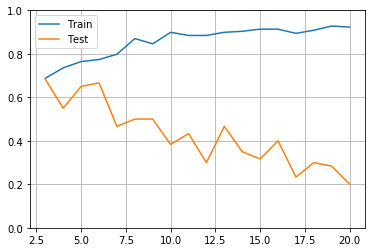

In [22]:
#On test de l'évolution des performances en fonction de la discrétisation 
nbEtats = np.arange(3, 21)
tauxTrain = np.zeros(nbEtats.size)
tauxTest = np.zeros(nbEtats.size)
for i, d in enumerate(nbEtats):
    tauxTrain[i], tauxTest[i] = evalModel(X, Y, d, 0.8) 
fig, ax = plt.subplots()
ax.grid(True)
ax.plot(nbEtats, tauxTrain, label = "Train")
ax.plot(nbEtats, tauxTest, label = "Test")
ax.legend()
ax.set_ylim((0,1))
plt.show()

On peut voir que plus on augmente le nombre d'états, pire la classification de l'ensemble de test devient. 

Cela arrive car avec une plus grande quantité d'états possibles on a une plus grande quantité de transitions avec probabilité = 0 et alors un signal qui pourra être classifié comme une lettre donnée ne le sera pas car une transition avec probabilité = 0 va ramener la vraisemblance du signal à cette lettre à 0. 

## Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [23]:
#On crée une nouvelle fonction pour calculer les modèles qui initialise chaque transition 
# avec un 1 pour qu'aucune probabilité soit a zero :

def learnMarkovModelAmeliore(Xc, nbEtats):
    A = np.ones((nbEtats, nbEtats))
    Pi = np.ones(nbEtats)
    
    for x in Xc:
        for i in range(x.size):
            if i == 0:
                Pi[int(x[i])] += 1
            else:
                ai = int(x[i - 1])
                aj = int(x[i])
                A[ai, aj] += 1
    
    A = A / np.maximum(A.sum(1).reshape(nbEtats, 1), 1) # normalisation
    Pi = Pi / Pi.sum()
    
    return Pi, A

In [24]:
#On utilise la focntion evalModel avec la nouvelle fonction de calcul de modèles :

tauxTrain20Ameliore, tauxTest20Ameliore = evalModel(X, Y, 20, 0.8, learnMarkovModelAmeliore)
print("Taux de bonne classification pour l'ensemble d'aprentissage, nbEtats = 20, pc = 0.8 : ", tauxTrain20Ameliore)
print("Taux de bonne classification pour l'ensemble de test, nbEtats = 20, pc = 0.8 : ", tauxTest20Ameliore)

Taux de bonne classification pour l'ensemble d'aprentissage, nbEtats = 20, pc = 0.8 :  0.8365384615384616
Taux de bonne classification pour l'ensemble de test, nbEtats = 20, pc = 0.8 :  0.5833333333333334


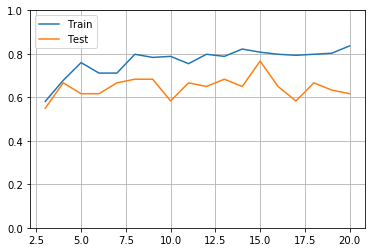

In [25]:
#test de l'évolution des performances en fonction de la discrétisation 
nbEtats = np.arange(3, 21)
tauxTrain = np.zeros(nbEtats.size)
tauxTest = np.zeros(nbEtats.size)
for i, d in enumerate(nbEtats):
    tauxTrain[i], tauxTest[i] = evalModel(X, Y, d, 0.8, learnMarkovModelAmeliore) 
fig, ax = plt.subplots()
ax.grid(True)
ax.plot(nbEtats, tauxTrain, label = "Train")
ax.plot(nbEtats, tauxTest, label = "Test")
ax.legend()
ax.set_ylim((0,1))
plt.show()

#on n'a plus de warnings de log(0) !

On peut voir que le taux de bonne classification pour l'ensemble de test ne diminue plus quand on augmente la quantité d'etats possibles.

# Partie optionnelle
## Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [26]:
conf = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

In [31]:
#On recrée les variables pour être sûr de ce qu'on a :

p = 0.8
nbEtats = 20
model = []

itrain, itest = separeTrainTest(Y, p)
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()
    
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num

Xd = discretise(X, nbEtats)  # application de la discrétisation
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    model.append(learnMarkovModelAmeliore(Xd[itrain[cl]], nbEtats))

proba = np.array([probasSequence(Xd[i], model) for i in range(Xd.size)])
pred = proba.argmax(1) # max ligne par ligne

for ligne, i in enumerate(pred):
    #print(i, Ynum[ligne])
    conf[i, int(Ynum[ligne])] += 1


- Tracé de la matrice : 

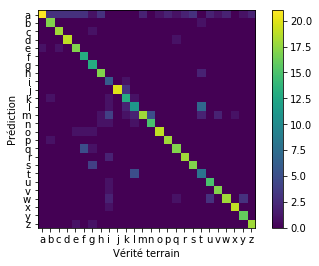

In [32]:
plt.figure()
plt.imshow(conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
plt.savefig("mat_conf_lettres.png")

## Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [29]:
# Votre code



### Affichage du résultat

In [30]:
newa = generate(models[0][0], models[0][1], 20)       # generation d'une séquence d'états
intervalle = 360. / d                                 # pour passer des états => valeur d'angles
newa_continu = np.array([i * intervalle for i in newa]) # conv int => double
tracerLettre(newa_continu)

NameError: name 'generate' is not defined